In [ ]:
import altair as alt
from vega_datasets import data

source = data.seattle_weather.url

step = 20
overlap = 1

alt.Chart(source, height=step).transform_timeunit(
    Month='month(date)'
).transform_joinaggregate(
    mean_temp='mean(temp_max)', groupby=['Month']
).transform_bin(
    ['bin_max', 'bin_min'], 'temp_max'
).transform_aggregate(
    value='count()', groupby=['Month', 'mean_temp', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['Month', 'mean_temp'], key='bin_min', value=0
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('bin_min:Q', bin='binned', title='Maximum Daily Temperature (C)'),
    alt.Y(
        'value:Q',
        scale=alt.Scale(range=[step, -step * overlap]),
        axis=None
    ),
    alt.Fill(
        'mean_temp:Q',
        legend=None,
        scale=alt.Scale(domain=[30, 5], scheme='redyellowblue')
    )
).facet(
    row=alt.Row(
        'Month:T',
        title=None,
        header=alt.Header(labelAngle=0, labelAlign='right', format='%B')
    )
).properties(
    title='Seattle Weather',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='end'
)

alt.FacetChart(...)

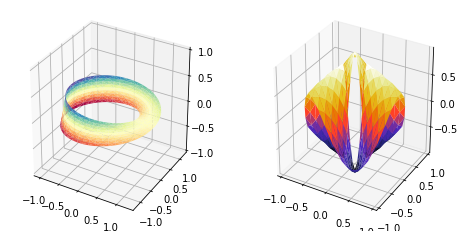

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


fig = plt.figure(figsize=plt.figaspect(0.5))

#============
# First plot
#============

# Make a mesh in the space of parameterisation variables u and v
u = np.linspace(0, 2.0 * np.pi, endpoint=True, num=50)
v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()

# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)

# Triangulate parameter space to determine the triangles
tri = mtri.Triangulation(u, v)

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.set_zlim(-1, 1)


#============
# Second plot
#============

# Make parameter spaces radii and angles.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi/n_angles

# Map radius, angle pairs to x, y, z points.
x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
z = (np.cos(radii)*np.cos(3*angles)).flatten()

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = mtri.Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = xmid**2 + ymid**2 < min_radius**2
triang.set_mask(mask)

# Plot the surface.
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(triang, z, cmap=plt.cm.CMRmap)


plt.show()

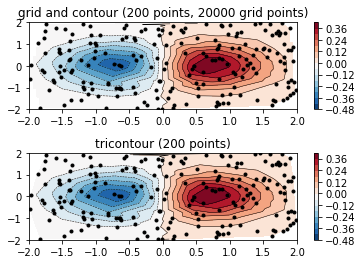

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = np.random.uniform(-2, 2, npts)
y = np.random.uniform(-2, 2, npts)
z = x * np.exp(-x**2 - y**2)

fig, (ax1, ax2) = plt.subplots(nrows=2)

# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
xi = np.linspace(-2.1, 2.1, ngridx)
yi = np.linspace(-2.1, 2.1, ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

# Note that scipy.interpolate provides means to interpolate data on a grid
# as well. The following would be an alternative to the four lines above:
#from scipy.interpolate import griddata
#zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-2, 2), ylim=(-2, 2))
ax1.set_title('grid and contour (%d points, %d grid points)' %
              (npts, ngridx * ngridy))

# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

ax2.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-2, 2), ylim=(-2, 2))
ax2.set_title('tricontour (%d points)' % npts)

plt.subplots_adjust(hspace=0.5)
plt.show()

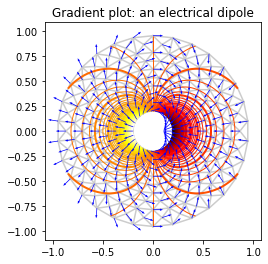

In [ ]:
from matplotlib.tri import (
    Triangulation, UniformTriRefiner, CubicTriInterpolator)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#-----------------------------------------------------------------------------
# Electrical potential of a dipole
#-----------------------------------------------------------------------------
def dipole_potential(x, y):
    """The electric dipole potential V, at position *x*, *y*."""
    r_sq = x**2 + y**2
    theta = np.arctan2(y, x)
    z = np.cos(theta)/r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))


#-----------------------------------------------------------------------------
# Creating a Triangulation
#-----------------------------------------------------------------------------
# First create the x and y coordinates of the points.
n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
V = dipole_potential(x, y)

# Create the Triangulation; no triangles specified so Delaunay triangulation
# created.
triang = Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

#-----------------------------------------------------------------------------
# Refine data - interpolates the electrical potential V
#-----------------------------------------------------------------------------
refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(V, subdiv=3)

#-----------------------------------------------------------------------------
# Computes the electrical field (Ex, Ey) as gradient of electrical potential
#-----------------------------------------------------------------------------
tci = CubicTriInterpolator(triang, -V)
# Gradient requested here at the mesh nodes but could be anywhere else:
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

#-----------------------------------------------------------------------------
# Plot the triangulation, the potential iso-contours and the vector field
#-----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_aspect('equal')
# Enforce the margins, and enlarge them to give room for the vectors.
ax.use_sticky_edges = False
ax.margins(0.07)

ax.triplot(triang, color='0.8')

levels = np.arange(0., 1., 0.01)
cmap = cm.get_cmap(name='hot', lut=None)
ax.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
              linewidths=[2.0, 1.0, 1.0, 1.0])
# Plots direction of the electrical vector field
ax.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,
          units='xy', scale=10., zorder=3, color='blue',
          width=0.007, headwidth=3., headlength=4.)

ax.set_title('Gradient plot: an electrical dipole')
plt.show()

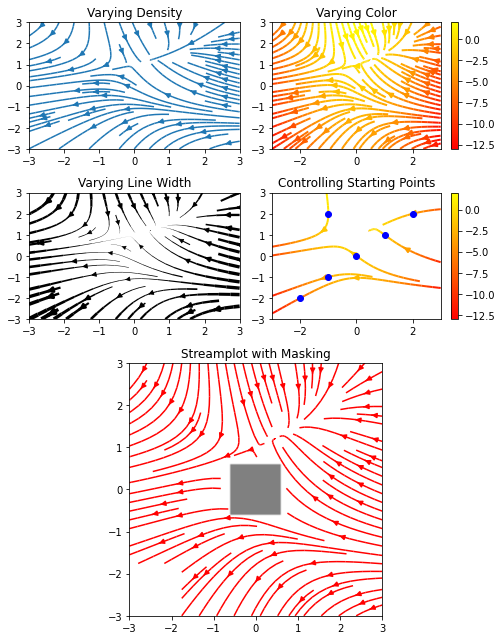

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig = plt.figure(figsize=(7, 9))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
ax0.streamplot(X, Y, U, V, density=[0.5, 1])
ax0.set_title('Varying Density')

# Varying color along a streamline
ax1 = fig.add_subplot(gs[0, 1])
strm = ax1.streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn')
fig.colorbar(strm.lines)
ax1.set_title('Varying Color')

#  Varying line width along a streamline
ax2 = fig.add_subplot(gs[1, 0])
lw = 5*speed / speed.max()
ax2.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
ax2.set_title('Varying Line Width')

# Controlling the starting points of the streamlines
seed_points = np.array([[-2, -1, 0, 1, 2, -1], [-2, -1,  0, 1, 2, 2]])

ax3 = fig.add_subplot(gs[1, 1])
strm = ax3.streamplot(X, Y, U, V, color=U, linewidth=2,
                      cmap='autumn', start_points=seed_points.T)
fig.colorbar(strm.lines)
ax3.set_title('Controlling Starting Points')

# Displaying the starting points with blue symbols.
ax3.plot(seed_points[0], seed_points[1], 'bo')
ax3.set(xlim=(-w, w), ylim=(-w, w))

# Create a mask
mask = np.zeros(U.shape, dtype=bool)
mask[40:60, 40:60] = True
U[:20, :20] = np.nan
U = np.ma.array(U, mask=mask)

ax4 = fig.add_subplot(gs[2:, :])
ax4.streamplot(X, Y, U, V, color='r')
ax4.set_title('Streamplot with Masking')

ax4.imshow(~mask, extent=(-w, w, -w, w), alpha=0.5, cmap='gray', aspect='auto')
ax4.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
import altair as alt
from vega_datasets import data

# Since the data is more than 5,000 rows we'll import it from a URL
source = data.zipcodes.url

alt.Chart(source).transform_calculate(
    "leading digit", alt.expr.substring(alt.datum.zip_code, 0, 1)
).mark_circle(size=3).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='leading digit:N',
    tooltip='zip_code:N'
).project(
    type='albersUsa'
).properties(
    width=650,
    height=400
)

alt.Chart(...)

In [ ]:
import plotly.express as px
df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

**Plot Only Hist and Curve**

In [ ]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200) - 2
x2 = np.random.randn(200)
x3 = np.random.randn(200) + 2

hist_data = [x1, x2, x3]

group_labels = ['Group 1', 'Group 2', 'Group 3']
colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, colors=colors,
                         bin_size=.2, show_rug=False)

# Add title
fig.update_layout(title_text='Hist and Curve Plot')
fig.

**Surface Plot With Contours**

In [ ]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

# Three-Dimensional Plotting in Matplotlib

Matplotlib was initially designed with only two-dimensional plotting in mind.
Around the time of the 1.0 release, some three-dimensional plotting utilities were built on top of Matplotlib's two-dimensional display, and the result is a convenient (if somewhat limited) set of tools for three-dimensional data visualization.
three-dimensional plots are enabled by importing the ``mplot3d`` toolkit, included with the main Matplotlib installation:

In [ ]:
from mpl_toolkits import mplot3d

Once this submodule is imported, a three-dimensional axes can be created by passing the keyword ``projection='3d'`` to any of the normal axes creation routines:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

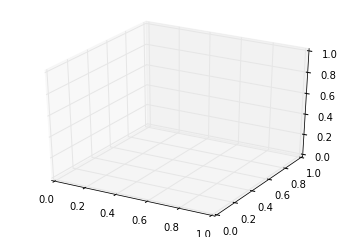

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

With this three-dimensional axes enabled, we can now plot a variety of three-dimensional plot types. 
Three-dimensional plotting is one of the functionalities that benefits immensely from viewing figures interactively rather than statically in the notebook; recall that to use interactive figures, you can use ``%matplotlib notebook`` rather than ``%matplotlib inline`` when running this code.

## Three-dimensional Points and Lines

The most basic three-dimensional plot is a line or collection of scatter plot created from sets of (x, y, z) triples.
In analogy with the more common two-dimensional plots discussed earlier, these can be created using the ``ax.plot3D`` and ``ax.scatter3D`` functions.
The call signature for these is nearly identical to that of their two-dimensional counterparts, so you can refer to [Simple Line Plots](04.01-Simple-Line-Plots.ipynb) and [Simple Scatter Plots](04.02-Simple-Scatter-Plots.ipynb) for more information on controlling the output.
Here we'll plot a trigonometric spiral, along with some points drawn randomly near the line:

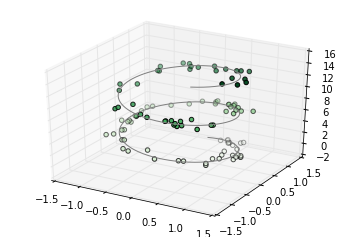

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

Notice that by default, the scatter points have their transparency adjusted to give a sense of depth on the page.
While the three-dimensional effect is sometimes difficult to see within a static image, an interactive view can lead to some nice intuition about the layout of the points.

## Three-dimensional Contour Plots

Analogous to the contour plots we explored in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb), ``mplot3d`` contains tools to create three-dimensional relief plots using the same inputs.
Like two-dimensional ``ax.contour`` plots, ``ax.contour3D`` requires all the input data to be in the form of two-dimensional regular grids, with the Z data evaluated at each point.
Here we'll show a three-dimensional contour diagram of a three-dimensional sinusoidal function:

In [ ]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

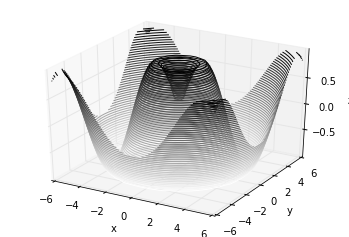

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Sometimes the default viewing angle is not optimal, in which case we can use the ``view_init`` method to set the elevation and azimuthal angles. In the following example, we'll use an elevation of 60 degrees (that is, 60 degrees above the x-y plane) and an azimuth of 35 degrees (that is, rotated 35 degrees counter-clockwise about the z-axis):

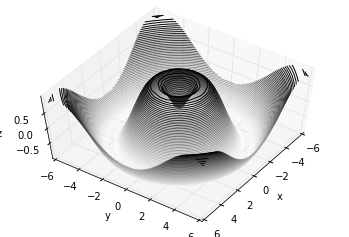

In [ ]:
ax.view_init(60, 35)
fig

Again, note that this type of rotation can be accomplished interactively by clicking and dragging when using one of Matplotlib's interactive backends.

## Wireframes and Surface Plots

Two other types of three-dimensional plots that work on gridded data are wireframes and surface plots.
These take a grid of values and project it onto the specified three-dimensional surface, and can make the resulting three-dimensional forms quite easy to visualize.
Here's an example of using a wireframe:

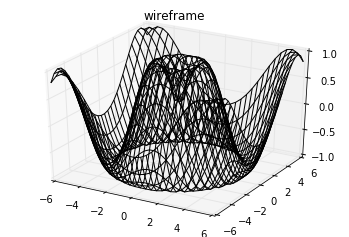

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('wireframe');

A surface plot is like a wireframe plot, but each face of the wireframe is a filled polygon.
Adding a colormap to the filled polygons can aid perception of the topology of the surface being visualized:

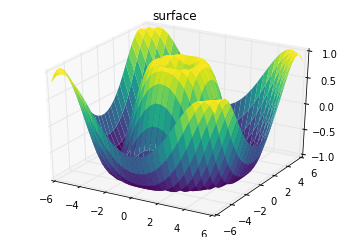

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

Note that though the grid of values for a surface plot needs to be two-dimensional, it need not be rectilinear.
Here is an example of creating a partial polar grid, which when used with the ``surface3D`` plot can give us a slice into the function we're visualizing:

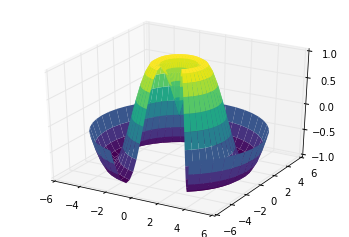

In [ ]:
r = np.linspace(0, 6, 20)
theta = np.linspace(-0.9 * np.pi, 0.8 * np.pi, 40)
r, theta = np.meshgrid(r, theta)

X = r * np.sin(theta)
Y = r * np.cos(theta)
Z = f(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');

## Surface Triangulations

For some applications, the evenly sampled grids required by the above routines is overly restrictive and inconvenient.
In these situations, the triangulation-based plots can be very useful.
What if rather than an even draw from a Cartesian or a polar grid, we instead have a set of random draws?

In [ ]:
theta = 2 * np.pi * np.random.random(1000)
r = 6 * np.random.random(1000)
x = np.ravel(r * np.sin(theta))
y = np.ravel(r * np.cos(theta))
z = f(x, y)

We could create a scatter plot of the points to get an idea of the surface we're sampling from:

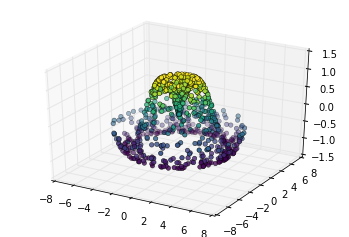

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

This leaves a lot to be desired.
The function that will help us in this case is ``ax.plot_trisurf``, which creates a surface by first finding a set of triangles formed between adjacent points (remember that x, y, and z here are one-dimensional arrays):

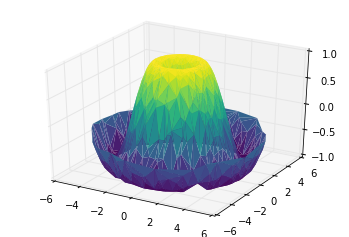

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z,
                cmap='viridis', edgecolor='none');

The result is certainly not as clean as when it is plotted with a grid, but the flexibility of such a triangulation allows for some really interesting three-dimensional plots.
For example, it is actually possible to plot a three-dimensional Möbius strip using this, as we'll see next.

### Example: Visualizing a Möbius strip

A Möbius strip is similar to a strip of paper glued into a loop with a half-twist.
Topologically, it's quite interesting because despite appearances it has only a single side!
Here we will visualize such an object using Matplotlib's three-dimensional tools.
The key to creating the Möbius strip is to think about it's parametrization: it's a two-dimensional strip, so we need two intrinsic dimensions. Let's call them $\theta$, which ranges from $0$ to $2\pi$ around the loop, and $w$ which ranges from -1 to 1 across the width of the strip:

In [ ]:
theta = np.linspace(0, 2 * np.pi, 30)
w = np.linspace(-0.25, 0.25, 8)
w, theta = np.meshgrid(w, theta)

Now from this parametrization, we must determine the *(x, y, z)* positions of the embedded strip.

Thinking about it, we might realize that there are two rotations happening: one is the position of the loop about its center (what we've called $\theta$), while the other is the twisting of the strip about its axis (we'll call this $\phi$). For a Möbius strip, we must have the strip makes half a twist during a full loop, or $\Delta\phi = \Delta\theta/2$.

In [ ]:
phi = 0.5 * theta

Now we use our recollection of trigonometry to derive the three-dimensional embedding.
We'll define $r$, the distance of each point from the center, and use this to find the embedded $(x, y, z)$ coordinates:

In [ ]:
# radius in x-y plane
r = 1 + w * np.cos(phi)

x = np.ravel(r * np.cos(theta))
y = np.ravel(r * np.sin(theta))
z = np.ravel(w * np.sin(phi))

Finally, to plot the object, we must make sure the triangulation is correct. The best way to do this is to define the triangulation *within the underlying parametrization*, and then let Matplotlib project this triangulation into the three-dimensional space of the Möbius strip.
This can be accomplished as follows:

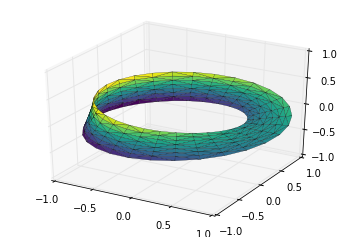

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation
tri = Triangulation(np.ravel(w), np.ravel(theta))

ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles,
                cmap='viridis', linewidths=0.2);

ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1);

Combining all of these techniques, it is possible to create and display a wide variety of three-dimensional objects and patterns in Matplotlib.